In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from networkx.readwrite import json_graph
import json

import pandas

import copy
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_connected_graph(net):
  # Get a list of connected components
  components = list(nx.connected_components(net))
  # Find the largest connected component
  largest_component = max(components, key=len)
  # Create a new graph containing only the largest component
  net_largest = net.subgraph(largest_component)
  # print warning
  if not nx.is_connected(net_largest):
    print("Graph is not connected")
  return(net_largest)



def create_net(filename):
  adjmat = pd.read_csv(filename)
  adjmat.rename(columns=lambda x: x.replace('.', '|'), inplace=True)
  # Create an empty graph
  tmpG= nx.Graph()

  # Iterate over the rows and columns of the DataFrame to add edges with weights
  for row in range(len(adjmat)):
    # print(adjmat.iloc[row, 0])
    source = adjmat.iloc[row, 0]
    target = adjmat.iloc[row, 1]
    weight = adjmat.iloc[row, 2]

    # Skip diagonal and negative edges
    if source != target and weight > 0:
        tmpG.add_edge(source, target, weight=weight)

  # get connected graph:
  net = get_connected_graph(tmpG)
  return(net)

In [ ]:
# METACARDIS
CAD_MC = create_net("metaCardis_cad_edges.csv")
HF_MC = create_net("metaCardis_hf_edges.csv")
IGT_MC = create_net("metaCardis_igt_edges.csv")
T2D_MC = create_net("metaCardis_t2d_edges.csv")
CTL_MC = create_net("metaCardis_control_edges.csv")
MS_MC = create_net("metaCardis_ms_edges.csv")

# HMP
IGT_HMP = create_net("hmp_igt_edges.csv")
CTL_HMP = create_net("hmp_control_edges.csv")

# KARLSSON
IGT_K = create_net("karlsson_igt_edges.csv")
T2D_K = create_net("karlsson_t2d_edges.csv")
CTL_K = create_net("karlsson_control_edges.csv")

# JIEZ
ACVD_JZ = create_net("jiez_acvd_edges.csv")
CTL_JZ = create_net("jiez_control_edges.csv")

# QINJ
T2D_QJ = create_net("qinj_t2d_edges.csv")
CTL_QJ = create_net("qinj_control_edges.csv")

In [5]:
CAD_col = "#fde725"
HF_col = "#90d743"
IGT_col = "#35b779"
T2D_col = "#21918c"
ACVD_col = "#31688e"
MS_col = "#443983"
CTL_col = "#440154"

In [6]:
disease_dict = {"CAD": {"color" : CAD_col, "linestyle" : "solid"},
            "HF": {"color" : HF_col, "linestyle" : "solid"},
            "IGT": {"color" : IGT_col, "linestyle" : "solid"},
            "T2D": {"color" : T2D_col, "linestyle" : "solid"},
            "ACVD": {"color" : ACVD_col, "linestyle" : "solid"},
            "MS": {"color" : MS_col, "linestyle" : "solid"},
            "CTL": {"color" : CTL_col, "linestyle" : "dashed"}}

In [7]:
study_dict = {"MetaCardis": {"CAD" : CAD_MC,
                             "HF" : HF_MC,
                             "IGT" : IGT_MC,
                             "T2D" : T2D_MC,
                             "MS" : MS_MC,
                             "CTL" : CTL_MC},
              "HMP" : {"IGT" : IGT_HMP, "CTL" : CTL_MC},
              "Karlsson" : {"IGT": IGT_K, "T2D" : T2D_K,
                            "CTL" : CTL_K},
              "JieZ" : {"ACVD" : ACVD_JZ, "CTL" : CTL_JZ},
              "QinJ" : {"T2D" : T2D_QJ, "CTL" : CTL_QJ}}

# Ataques a la red

## Ataque aleatorio
La función que utilizamos hace lo siguiente:
1. Selecciona un nodo aleatorio dentro de la lista de nodos
2. Elimina el nodo del grafo
3. Obtiene el tamaño del mayor componente conexo

Después visualizamos el tamaño de la mayor componente conexa en función del número de nodos eliminados.

In [8]:
def remove_random_node(g, n):
  lcc_sizes = []
  for i in range(n):
    node = random.choice(list(g.nodes()))
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    lcc_sizes.append(lcc_size)
  return(lcc_sizes)

In [9]:
nreps = 100

In [10]:
def plot_attack(net, plot_net, sd_net,
                       col = "black",
                       line = "solid",
                       lab = "Network"):
  x_vals_net = [i/net.order() for i in range(net.order())]
  net_rand_to_plot = np.array([i/net.order() for i in plot_net])
  net_rand_to_plot_sd = np.array([i/net.order() for i in sd_net])
  plt.plot(x_vals_net, net_rand_to_plot,
         label =lab, color = col, linestyle = line)
  plt.fill_between(x_vals_net,
                 net_rand_to_plot - net_rand_to_plot_sd,
                 net_rand_to_plot + net_rand_to_plot_sd,
                 color = col, alpha=0.2)


MetaCardis #################################
CAD
HF
IGT
T2D
MS
CTL


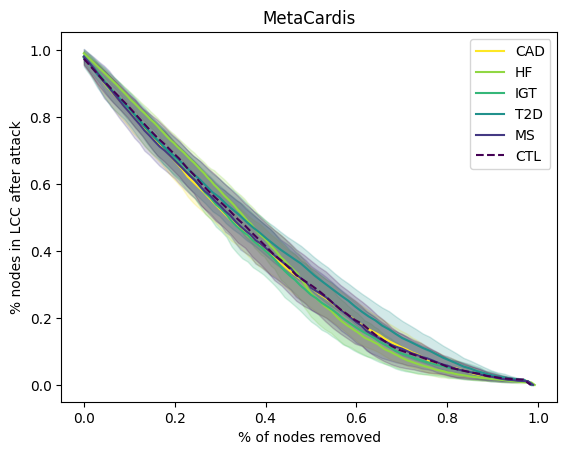

HMP #################################
IGT
CTL


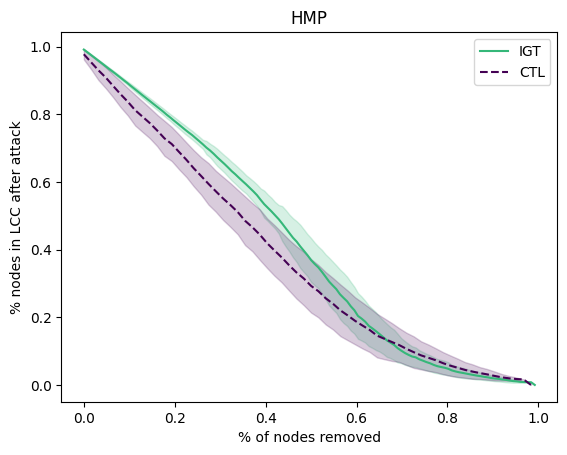

Karlsson #################################
IGT
T2D
CTL


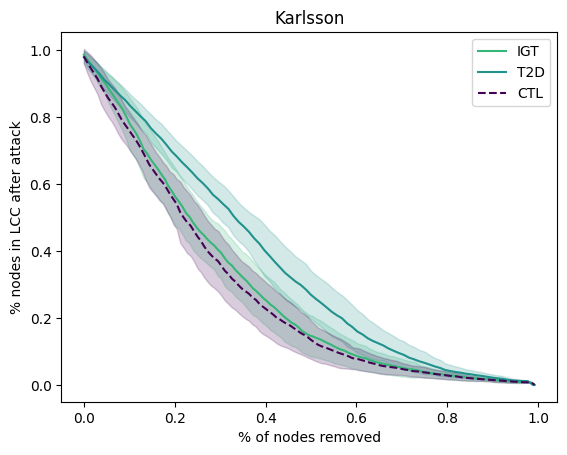

JieZ #################################
ACVD
CTL


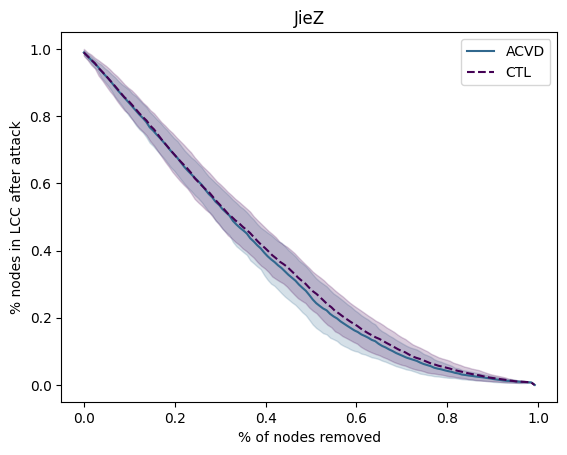

QinJ #################################
T2D
CTL


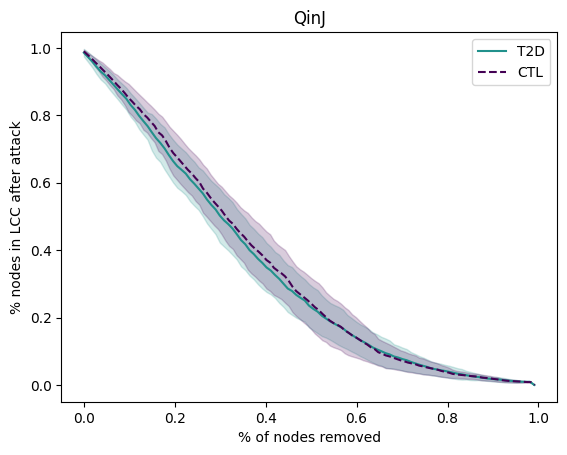

In [11]:
for study in study_dict:
  print(study, "#################################")
  for disease in study_dict[study]:
    print(disease)
    disease_lcc_sizes_random = []
    while len(disease_lcc_sizes_random) < nreps:
      net_kk = nx.Graph(study_dict[study][disease]) # copia para no cargarnos el original
      disease_lcc_sizes_random.append(remove_random_node(net_kk, net_kk.order()))

    arr_dis = np.array(disease_lcc_sizes_random)
    plot_dis = np.mean(arr_dis, axis = 0)
    sd_dis = np.std(arr_dis, axis = 0)

    plot_attack(study_dict[study][disease],
                plot_dis, sd_dis,
                disease_dict[disease]["color"],
                disease_dict[disease]["linestyle"],
                disease)
  plt.ylabel("% nodes in LCC after attack")
  plt.xlabel("% of nodes removed")
  plt.legend()
  plt.title(study)
  plt.show();

# Nodos a eliminar para desmontar 50% de la red

In [12]:
nreps = 100

In [13]:
threshold = .5 # proporcion de nodos que quedan

In [14]:
def remove_random_node(g, n):
  number_of_attacks = 0
  gOrder = g.order()
  lcc_size = g.order()
  for i in range(n):
    number_of_attacks += 1
    node = random.choice(list(g.nodes()))
    g.remove_node(node)
    try:
      lcc_size = len(max(nx.connected_components(g), key=len))
    except:
      lcc_size = 0
    if lcc_size/gOrder <= threshold:
      break

  return(number_of_attacks/gOrder)

In [15]:
threshold_dict = {}
for study in study_dict:
  threshold_dict[study] = {}
  for disease in study_dict[study]:
    disease_thresholds = []
    while len(disease_thresholds) < nreps:
      net_kk = nx.Graph(study_dict[study][disease])
      a50 = remove_random_node(net_kk, net_kk.order())
      disease_thresholds.append(a50)
    threshold_dict[study][disease] = disease_thresholds

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
my_pal = {"CAD" : CAD_col, "HF" : HF_col,
          "IGT" : IGT_col, "T2D" : T2D_col,
          "ACVD" : ACVD_col, "MS" : MS_col,
          "CTL" : CTL_col}

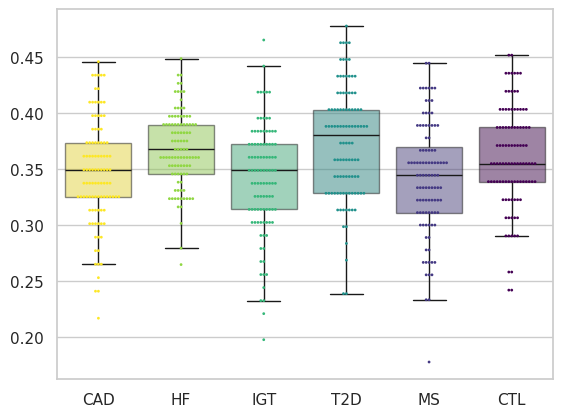

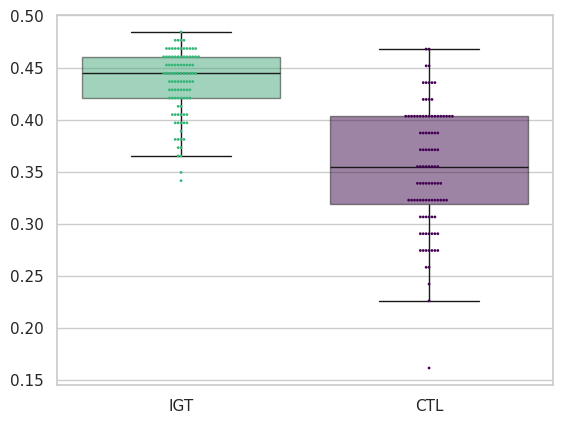

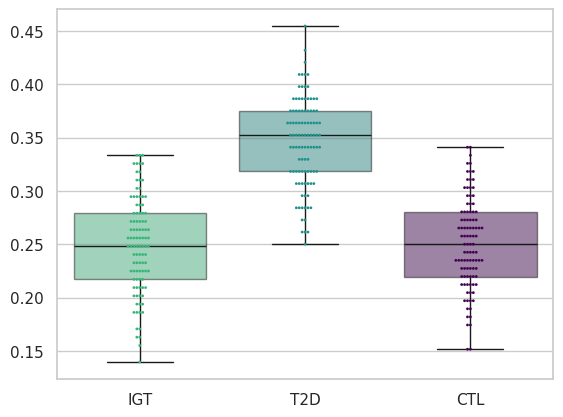

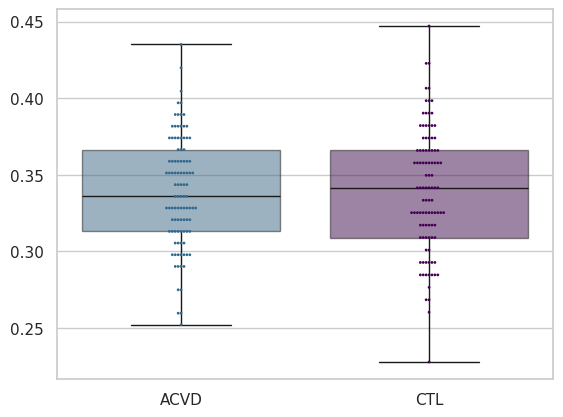

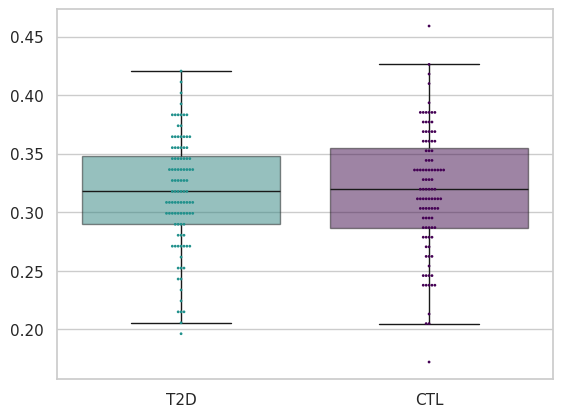

In [17]:
for study in threshold_dict:
  a50_dict = threshold_dict[study]
  df = pd.DataFrame(data = a50_dict)
  ax = sns.boxplot(data = df, showfliers = False, boxprops=dict(alpha=.5),
                 palette = my_pal)
  ax = sns.swarmplot(data = df,
                     size = 2,
                     palette = my_pal)
  plt.show()